# Classification tests - Testing K Nearest Neighbors, Random Forest and Support Vector Classifications using a test set of 50 documents
## Try these 3 different models to classify with word vectors of candidates generated via word2vec 
## Try these 3 different models to classify PS-similarity measures from candidates generated via word2vec


In [34]:
# -*- coding: utf-8 -*-
from   __future__ import division
import os
import re
import sys
import csv
import math
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from   matplotlib.colors import ListedColormap
from   sklearn import neighbors, datasets
import gensim, logging
from gensim.models import FastText
import fasttext


from   sklearn import svm
from   sklearn.svm import SVR
from   sklearn.svm import SVC
from   sklearn.metrics import f1_score, precision_score, recall_score
import sklearn
import spacy

from   sklearn.model_selection import train_test_split
from   sklearn.model_selection import GridSearchCV
from   sklearn.metrics import classification_report
from   sklearn.neural_network import MLPClassifier

from   sklearn.manifold import TSNE

from   sklearn.ensemble import RandomForestRegressor
from   sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit
import scipy as sp
import _pickle as pkl
#import cPickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from   sklearn.ensemble import RandomForestClassifier

# This log shows progress and is very useful
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Load spacy for candidate processing
nlp = spacy.load("en_core_web_sm")
# Adding these into the vocabulary
nlp.vocab[u"diblock"].is_stop = False
nlp.vocab[u"g/mol"].is_stop   = False
nlp.vocab[u"kg/mol"].is_stop  = False

In [143]:
GROUND_TRUTH_INPUT = "../ground_truth/ground_truth_list_format.txt"
FULL_CANDIDATES = "../../data/polymer_ner_evaluation.csv"
CBOW_MODEL = "../../models/FT_cbow.bin"

Below, we will create a file with all of the sentences from the processed_sentence column in 
sentences table. This file will serve as the training file for the fasttext unsupervised learning algorithm,
and the vectors will then be used for clustering and classification. 

In [107]:
# Connect to db
def connect_to_db():
    database = "../../db/sentences.db"
    conn = create_connection(database)
    return conn
# Connect to DB
def create_connection(db_file):
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Exception as e:
        print(e)
 
    return None

# Get sentences
def get_sentences_from_db(conn):
    sentences = ''
    cur = conn.cursor()
    cur.execute("select processed_sentence from sentences") 
    rows = cur.fetchall()
    
    with open('processed_sentences.txt','w',encoding="utf-8") as f:
        for row in rows:
             f.write(row[0]+'\n')



First, we will train the FastText algorithm on polymers.test . The polymers.test includes 150 documents. 

In [108]:
conn = connect_to_db()
get_sentences_from_db(conn)

Below, we will get the models both for the supervised vectors and unsupervised vectors.

In [109]:
supervised_model = fasttext.train_supervised('../../data/polymers.test')
unsupervised_model = fasttext.train_unsupervised('processed_sentences.txt')

<h1>Data Exploration</h1> <br><br>
First, we will take a look at the polymers from the ground_truth file and see which ones are the most popular based
on their frequency in the data.test file

In [148]:
test = pd.read_table("../../data/polymers.test",encoding="utf-8",header=None)

In [145]:
def word_list_from_doc(test_data):
    """processes dfs where original file 
    is of the form [label, sentence] """
    
    sentences_to_words = []
    
    df = pd.DataFrame(test_data[0].str.split(" ",1))
    sentences = df[0].str[1].apply(lambda x: x.lstrip('b'))
    
    for sentence in sentences:
        words = sentence.split(" ")
        for word in words:
            sentences_to_words.append(word)
    
    return sentences_to_words

def get_ground_truths(gt_input):
    with open(gt_input, 'r') as f:
        ground_truths = f.readlines()
        
    return [ground_truth.strip('\n') for ground_truth in ground_truths]

In [149]:
ground_truths = get_ground_truths(GROUND_TRUTH_INPUT)
word_counts = Counter(word_list_from_doc(test))
word_counts_sorted = {k: v for k, v in sorted(word_counts.items(), key=lambda item: item[1],reverse=True)}
ground_truth_counts = {k: word_counts[k] for k in ground_truths}
ground_truth_counts = {k: v for k, v in sorted(ground_truth_counts.items(), key=lambda item: item[1],reverse=True)}

In [147]:
#word_counts_sorted

In [150]:
#ground_truth_counts

Based on the above, I have the following ideas...
1. Add a feature for has_numeric. 1 if word has numeric AND has alphabetic chars, 0 else.
2. has_dash - This returns 1 if contains "-", else 0.
3. has_parentheses - This feature value is 1 if contains "(" and ")" else 0.
4. has_slash - 1 if contains "/" or "\" else 0.
5. contains_poly - returns 1 if "poly" in lowercase string, else 0. This is most questionable feature as this info should be somewhat accounted for in similarity measure vector approach
6. len string - Also somewhat questionable as it could double based on similarity measure used against 3 common polymers. 

Proposal, keep "PS" similarity measure as feature to hopefully help find the abbreviated polymers. Remove other 2
as those ones might fair better with binary attributes contains_poly and has_parentheses especially if using
a tree based classification approach.

Also, on top of the English word removal, potentially add common abbreviations such as i.e. and e.g. 


In [38]:
#Gets candidates from a fulldocument of candidates text file
def get_fulldoc_candidates(doc_path):
    with open(doc_path,'r', encoding='utf-8') as f:
        candidates = f.readlines()
        
    return [candidate.strip('\n') for candidate in candidates]

In [39]:
def get_training_testing_data(features, target):
    # Dataset, training and testing datasets
    X = np.asarray(features)
    y = np.asarray(target)
    Xtrain, Xtest, ytrain, ytest = train_test_split(
        X, y, test_size=0.1, random_state=0)
    return Xtrain, Xtest, ytrain, ytest

In [40]:
# Get metrics - I think I can do that with scikit learn
def metrics(predicted, actual):  
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    num_pos = 0
    num_polys = 0
    for i in range(len(predicted)):
        if predicted[i] == 1 and actual[i] == 1:
            true_pos = true_pos + 1
        elif predicted[i] == 1 and actual[i] == 0:
            false_pos = false_pos + 1
        elif predicted[i] == 0 and actual[i] == 0:
            true_neg = true_neg + 1
        elif predicted[i] == 0 and actual[i] == 1:
            false_neg = false_neg + 1

    print('    Test points:     %d' % len(predicted))
    print('    True positives:  %d' % true_pos)
    print('    False positive:  %d' % false_pos)
    print('    True negatives:  %d' % true_neg)
    print('    False negatives: %d' % false_neg)
    if false_pos+true_pos > 0:
        precision = true_pos/(true_pos+false_pos)

        recall = true_pos/(true_pos+false_neg)
        accuracy = (true_pos + true_neg)/(true_pos+true_neg+false_pos+false_neg)
        f1score = 2/((1/recall)+(1/precision))
    else: #FIXME
        precision = 0
        recall = 1
        f1score = -1 #FIXME: check 
    print('    Precision:       %.3f' % precision)
    print('    Recall:          %.3f' % recall)
    #print "Accuracy: ", accuracy / just to check my metrics function was correct
    print('    F-1 score:       %.3f' %f1score)
    #print clf.score(predicted,actual)
    return f1score

In [41]:
# Check if a string is a number
def is_number(n):
    try:
        float(n)
        return True
    except ValueError:
        return False

# First use vectors as features
def refine_candidate(candidate,model):
    # Top context words in DB
    frequent_context_words = ["weight","material","system","chains","samples", "systems","Tg","weights","comparison","chromatography","Mn","THF","toluene","GPC","chloroform","index","Column","columns","standards","reference","segments","polydispersity","substrate","block","components","permeation","component","Mw","bulk","standard","calibration","dynamics","cross-linked","cells","domains","segment","mixtures","densities","substrates","well-defined","silica","SEC","particles","compositions","surfaces","linear"]
    
    common_polys = ['polyethylene', 'polyurethane', 'polypropylene', 'polyester', 'PS', 'polystyrene', 'PLA', 'PI', 'PET', 'PVP', 'PEG', 'cellulose', 'PAN', 'methyl'] #These are polymers that could appear within spacy vocab
    common_polys = [polymer.lower() for polymer in common_polys] 

    # Filter out junk values
    junk_vals = []
        
    if (candidate in nlp.vocab) and candidate.lower() not in common_polys:
        return "ignore_due_to_english_word"
    
    try:
#         vocab_obj = model.get_word_vector(candidate) #model.wv.vocab[candidate]
#         freq= vocab_obj.count

        if candidate in frequent_context_words:
            return "ignore_due_to_context"

        junk = False
        items = re.split(' |:|;|-',candidate)
        for item in items:
            #Removing items that are sentences within  parenthesis
            if item != "poly" and is_number(item)==False and ("standard" in item or (item in nlp.vocab and item not in common_polys)):
                junk = True
                break

        if junk is True:
            return "ignore_due_to_junk"
    except:
        return "ignore_due_to_not_in_model"
        
    return "acceptable_after_refinement"

In [54]:
# Define KNN, SVC, and RF models

def knn(Xtrain,Xtest, ytrain, ytest):
    # Number of neighbors 5 seems to work best
    n_neighbors = 5

    #for weights in ['uniform', 'distance']:
    weights = 'uniform'
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)

    clf.fit(Xtrain,ytrain)

    y_predicted = clf.predict(Xtest)
    f1s = metrics(y_predicted,ytest)
    #print "Classifier score (accuracy): ", clf.score(Xtest,ytest)
   # return f1s
    print("LEN X TRAIN {}".format(str(len(Xtrain))))
    print("LEN X TESST {}".format(str(len(Xtest))))
    print("LEN Y PREDICTED {}".format(str(len(ytest))))
    return {'y_predicted': y_predicted, 'f1s': f1s}


def svc(Xtrain, Xtest, ytrain, ytest):
    # Set the parameters by cross-validation
    tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

    scores = ['precision', 'recall']
    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % scores[1])
    clf.fit(Xtrain, ytrain)
    #print(clf.best_params_)
    clf = clf.best_estimator_
    y_pred = clf.predict(Xtest)
    f1s = metrics(y_pred,ytest)
   # return f1s
    return {'y_predicted': y_pred, 'f1s': f1s}

def RF(Xtrain, Xtest, ytrain, ytest):
    param_grid = { 
        'max_features': ['auto', 'sqrt', 'log2']
    }
    
    clf = RandomForestClassifier(max_depth=None, n_jobs=-1, max_features= 'sqrt' ,n_estimators=100, oob_score = True, random_state=None)
    clf = GridSearchCV(RandomForestClassifier(n_estimators=100),
                    param_grid=param_grid,
                    scoring='f1',
                    cv=10)
    #clf = RandomForestClassifier(max_depth=None, max_features=3, random_state=None) # Change when using similarity scores
    clf.fit(Xtrain, ytrain)
    clf = clf.best_estimator_
    y_predicted = clf.predict(Xtest)
    f1s = metrics(y_predicted,ytest)
   # return f1s
    return {'y_predicted': y_predicted, 'f1s': f1s}


def run_all_models(X, y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag):
    print('Running all classifiers, with %s candidates; %s; %s' % 
      ('refined' if refined_candidates_only_flag else 'unrefined',
       'word vectors' if use_word_vector_flag else 'score vectors',
       'full documents' if process_full_document_flag else 'classified sentences'))

  #  X, y = get_word_vectors_as_feature(connection, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
    
    best_model1, max_f1_score1, predictions = run_all_classifiers(X, y)
    key = ('fulldoc' if process_full_document_flag else 'classified_sentences') + '_' + ('refined' if refined_candidates_only_flag else 'unrefined') + '_' + ('words' if use_word_vector_flag else 'scores')
    results[key] = [best_model1, max_f1_score1]
    return predictions

In [42]:
# Run all classifiers on a particular type of input
def run_all_classifiers(X,y):
    print("RUNNING THEM ALL NOW LENGTH OF X, y IS {} {}".format(str(len(X)),str(len(y))))
    models = ['K Nearest Neighbor', 'Support Vector', 'Random Forest']
    f1_scores = []
    X_train, X_test, y_train, y_test = get_training_testing_data(X,y)
    print(X_train)
    print('K Nearest Neighbor:')
    knn_results = knn(X_train, X_test, y_train, y_test)
    print(knn_results)
    knn_predictions,f1_score1 = knn_results['y_predicted'],knn_results['f1s']
    f1_scores.append(f1_score1)
    
    print('Support Vector:')
    svc_results = svc(X_train, X_test, y_train, y_test)
    svc_predictions, f1_score2 = svc_results['y_predicted'], svc_results['f1s']
    f1_scores.append(f1_score2)
    
    #print('Multi Layer Perceptron:')
    #f1_score3 = MPC(X_train, X_test, y_train, y_test)
    #print f1_score3
    #f1_scores.append(f1_score3)
    
    print('Random Forest:')
    rf_results = RF(X_train, X_test, y_train, y_test)
    rf_predictions, f1_score4 = rf_results['y_predicted'],rf_results['f1s']
    f1_scores.append(f1_score4)
    max_f1 = max(f1_scores)
    max_f1_index_arr = np.where(np.array(f1_scores)==max_f1)

    for mf in range(len(max_f1_index_arr[0])):
        max_f1_index = max_f1_index_arr[0][mf]
        print ('%s achieves the best F1 score of %.3f' % (models[max_f1_index], f1_scores[max_f1_index]))
    best_model = models[max_f1_index],f1_scores[max_f1_index]
    
    return(best_model, 
           max_f1,
           {'knn_pred':knn_predictions,
            'svc_pred':svc_predictions,
            'rf_pred':rf_predictions})

In [43]:
def get_coords(words,model):
    coords = []
    for word in words:
        try:
            coords.append(model.wv.vocab[word])
        except:
            coords.append([0])
        
    return coords

def get_similarity_scores_as_features(polymer_candidates, model, frequent_polymers):
    from sklearn.metrics.pairwise import cosine_similarity
    # Polymers used to generate training data
   # frequent_polymers = ["polystyrene","poly(styrene)","PS"]

    features = {}
    Xl = [] # vectors
    yl = [] # target (is_poly=0:1?)
    ll = [] # labels
    
   # similarities = {}
    for candidate in polymer_candidates:
        features[candidate] = []
        candidate_vec = model.get_word_vector(candidate).reshape(1, -1)
        
        try:
            for fp in frequent_polymers:
                fp_vec = model.get_word_vector(fp).reshape(1, -1)
                similarity_score = cosine_similarity(candidate_vec,fp_vec)#round(model.wv.similarity(candidate,fp),2)
                features[candidate].append(similarity_score[0][0])

            Xl.append(features[candidate])
            yl.append(candidate)
        except Exception as e:
            print(e)
            continue
            
    return Xl

**Clustering Setup ** 

In [171]:
def get_hashes_from_list(list_):
    """returns dictionary with value 1 from a list. Its purpose is to be used when needing to find if 
    item is in a list repeatedly as this will get the find operation down to constant time."""
    return {key: 1 for key in list_}
def create_df(candidates, model,ground_truths=None):
    # is_{algo} columns are boolean as to whether or not they were predicted by that algorithm. 
    df = pd.DataFrame(columns=["candidate","is_knn","is_svc","is_rf","is_groundtruth","db_scan_clus","predictions","is_refined"])
    #ground_truths_hashed = get_hashes_from_list(ground_truths)
    
    if isinstance(candidates,str):
        with open(candidates,'r',encoding='utf-8') as candidates:
            for candidate in candidates:
                word_and_isgroundtruth = candidate.split("|")
                word = word_and_isgroundtruth[0].replace('"','')
                is_refined = refine_candidate(word, model)
                is_groundtruth = int(word_and_isgroundtruth[1].replace('"','').rstrip('\n'))

            # is_groundtruth = 1 if word in ground_truths_hash else 0
                df = df.append({"candidate":word,"is_groundtruth":is_groundtruth,"db_scan_clus":None,"supervised_coords":[],"unsupervised_coords":[],"is_refined": is_refined},ignore_index=True)

    else:
        ground_truths_hashed = get_hashes_from_list(ground_truths)
        for candidate in candidates:
            is_refined = refine_candidate(candidate,model)
            is_groundtruth = candidate in ground_truths_hashed
            df = df.append({"candidate":candidate,"is_groundtruth":is_groundtruth,"db_scan_clus":None,"supervised_coords":[],"unsupervised_coords":[],"is_refined": is_refined},ignore_index=True)

    return df

<h1> Experiment 1 </h1><br>
The first experiment will be to go through the process as defined in the paper utilizing 
the terms from the 500 documents with the terms frfom the ground_truth file to see how clustering and the classifiers perform.
This will use the cosine similaeity scores with the array ["polystyrene","poly(styrene)","PS"] as features. 

In [111]:
df_exp1 = create_df(FULL_CANDIDATES, supervised_model)
df_exp1 = df_exp1[df_exp1.is_refined=="acceptable_after_refinement"]

In [119]:
candidates = df_exp1.candidate
supervised_coords = get_similarity_scores_as_features(candidates, supervised_model,  ["polystyrene","poly(styrene)","PS"])
unsupervised_coords = get_similarity_scores_as_features(candidates, unsupervised_model,  ["polystyrene","poly(styrene)","PS"])
df_exp1.supervised_model_coords = supervised_coords
df_exp1.unsupervised_model_coords = unsupervised_coords

C:\Users\danlg\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """


In [113]:
df_exp1

,candidate,is_knn,is_svc,is_rf,is_groundtruth,db_scan_clus,predictions,is_refined,model_coords
0,DNA,0,0,0,0,None,NaN,acceptable_after_refinement,"[-0.9956413, -0.9864065, -0.96618384]"
2,semidilute,0,0,0,0,None,NaN,acceptable_after_refinement,"[-0.9742995, -0.9674851, -0.95164067]"
3,well-entangled,0,0,0,0,None,NaN,acceptable_after_refinement,"[-0.63267654, -0.63258857, -0.60784334]"
7,fluids,0,0,0,0,None,NaN,acceptable_after_refinement,"[0.53739655, 0.52752966, 0.5192265]"
12,broad.23,0,0,0,0,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]"
...,...,...,...,...,...,...,...,...,...
1104,2 to 7,0,0,0,1,None,NaN,acceptable_after_refinement,"[0.0, 0.0, 0.0]"
1105,polydimethylsiloxane,0,0,0,1,None,NaN,acceptable_after_refinement,"[0.9808457, 0.9674403, 0.9524896]"
1106,four-armed,0,0,0,1,None,NaN,acceptable_after_refinement,"[0.841585, 0.82723963, 0.8095096]"
1107,rodlike,0,0,0,1,None,NaN,acceptable_after_refinement,"[-0.35197884, -0.35230455, -0.32604563]"


In [73]:
def get_X_from_df(series_col):
    arr = []
    for coords in series_col:
        arr.append([float(coord) for coord in coords])
        
    return arr

Read more about the algorithms...
https://scikit-learn.org/stable/modules/clustering.html#optics
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html

In [242]:
from sklearn.cluster import DBSCAN, AgglomerativeClustering, OPTICS, KMeans

def run_dbscan(X):
    clustering = DBSCAN().fit(X)
    return clustering.labels_
    
def run_kmeans(X,params):
    clustering = KMeans(**params).fit(X)
    return clustering.labels_

def run_optics(X,args):
    optics = OPTICS(**args).fit(X)
    return optics.labels_

def run_agg_clustering(X,args):
    clustering = AgglomerativeClustering(**args).fit(X)
    return clustering.labels_



In [195]:

def get_cluster_homogeneity(labels,words,ground_truths_hash):
    cluster_frequency = Counter(labels)
    ground_truths_in_clus = {k: 0 for k in labels}
    
    for ix in range(0,len(words)):
        candidate = words[ix]
        cluster_label = labels[ix]
        if candidate in ground_truths_hash:
            ground_truths_in_clus[cluster_label] += 1
            
    return ground_truths_in_clus, cluster_frequency

def get_homogeneity_proportion(ground_truths_in_clus, cluster_frequency):
    return {k: ground_truths_in_clus[k]/cluster_frequency[k] for k in list(cluster_frequency)}

In [188]:
X = np.array(get_X_from_df(df_exp1.supervised_model_coords))
X = pd.DataFrame(X)

dbscan_labels = run_dbscan(X)
agg_labels = run_agg_clustering(X)
optics_labels = run_optics(X)
df_exp1["db_scan_labels"] = dbscan_labels
df_exp1["agg_labels"] = agg_labels
df_exp1["optics_labels"] = optics_labels

C:\Users\danlg\Anaconda3\lib\site-packages\sklearn\cluster\optics_.py:791: RuntimeWarning: divide by zero encountered in true_divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [115]:
Counter(run_dbscan(X))

Counter({0: 1036})

In [115]:
set(df_exp1["db_scan_labels"])

{0}

In [116]:
get_cluster_homogeneity(df_exp1.db_scan_labels,df_exp1.candidate,ground_truths_hash)

({0: 50}, Counter({0: 1109}))

In [117]:
get_cluster_homogeneity(df_exp1.agg_labels,df_exp1.candidate,ground_truths_hash)

({0: 17, 1: 33}, Counter({0: 572, 1: 537}))

Coordinates plotting


In [126]:
def tsne_plot_candidates(model, df,colors, clus_labels_name, outfile = "./clustering_coords.png"):


    tsne_model = TSNE(perplexity=5, n_components=2, init='pca', n_iter=250, random_state=23)
    all_values = tsne_model.fit_transform(df)
    
    x0 = []
    y0 = []

    for value in all_values:
        x0.append(value[0])
        y0.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
        
    print("Beginning plotting..")
    for i in range(len(x0)):
        plt.scatter(x0[i],y0[i], color=colors[df.loc[i,clus_labels_name]])

        
    plt.legend(colors.keys(), loc="upper left")
    plt.savefig(outfile, format="png")
    plt.show()
    plt.close()

colors = {-1:'blue', 0: 'red', 1: 'green', 2: 'cyan', 3: 'black', 4: 'magenta'}
tsne_plot_candidates(model, clus_df,colors,"db_scan_labels")


NameError: name 'clus_df' is not defined

Beginning plotting..
{0: 'red', 1: 'black'}


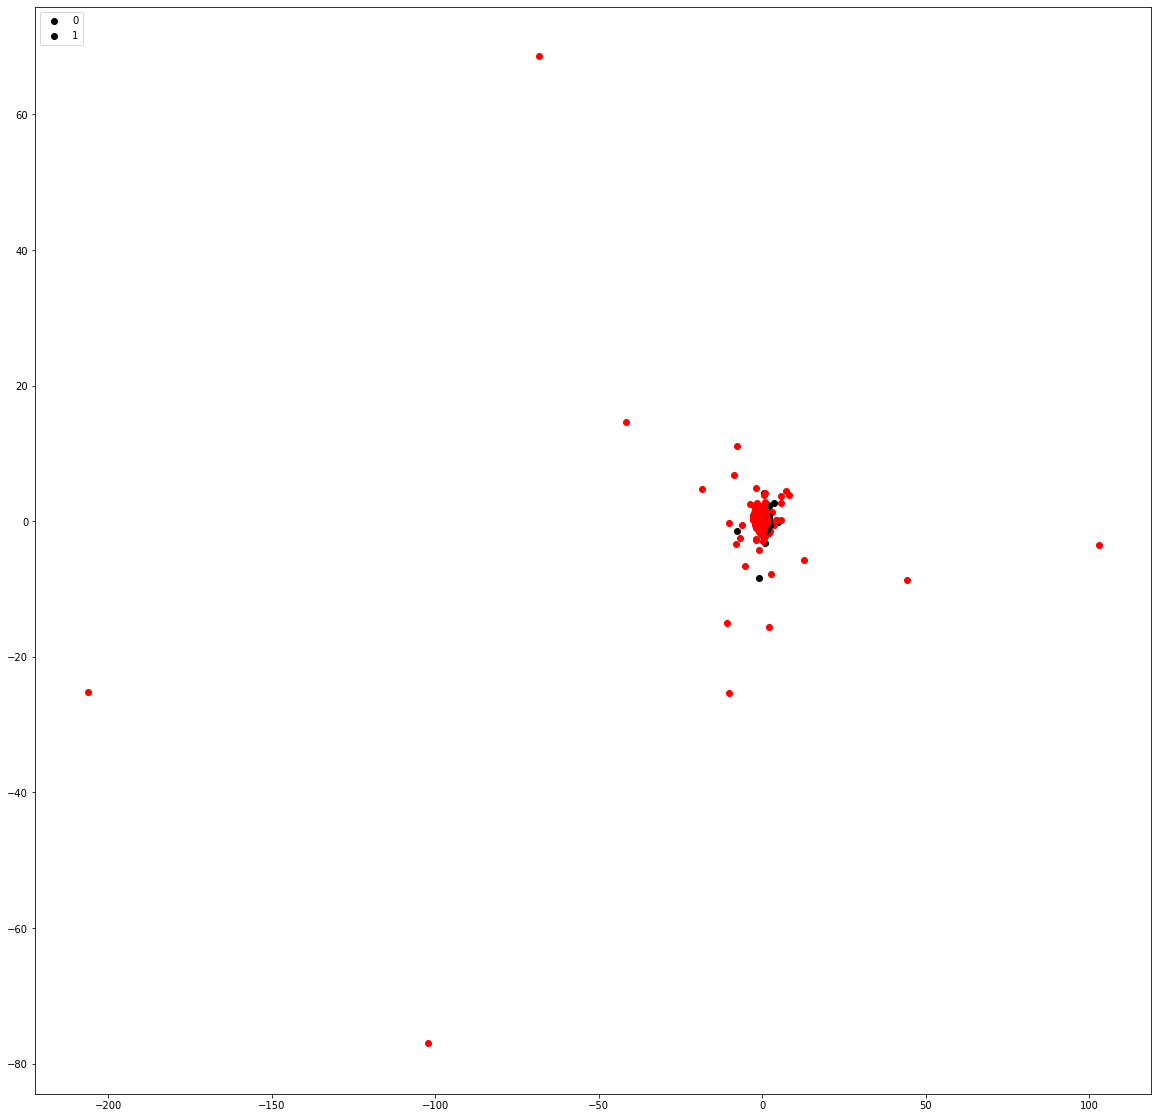

In [111]:
colors = {0: 'red', 1: 'black'}
tsne_plot_candidates(model, clus_df,colors,"agg_labels")

In [109]:
set(agg_labels)

{0, 1}

## Run all models eight times

Run each of the classifiers for the following 2 x 2 x 2 = 8 configurations:
1. (all docs vs. fasttext-selected)
1. (refined vs. unrefined)
1. (word vector vs. score vectors)

In [116]:
# Keep a list of best models and best F scores
results = {}

## Found error problem
The error in the cell below is symbols that cannot be detected by unicode
for ex... 700â€‰000 is one where the middle is replaces with \u and it is re-intepreted to '700\u2009000'
This can be found in the excel sheet by searching 'SV-N-NA' and then moving over 2 cells. 

Another example is Mp = 1050âˆ’1â€‰870â€‰000 g/mol

We need to figure out where file 'classifier_pipeline_candidates.csv' was created to potentially see how this came to be.

In the meantime, a temp try except fix can be created but MUST be labeled in order for it to eventually be removed.

<br>


The results from running the models when trying to reproduce the original experiment were as follows. The data model from polymers.TEST file with the fasttext supervised training. 
Then, the refined model was run through the classification process where KNN, SVC with gridsearch, and RF with gridsearch were used to predict the candidate's valdiity. The results were as follows when doing this method...
    

In [121]:
process_full_documevbghnt_flag   = True
refined_candidates_only_flag = False
use_word_vector_flag         = False
y = df_exp1.is_groundtruth.astype('int')

predictions = run_all_models(X,y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
predictions

Running all classifiers, with unrefined candidates; score vectors; full documents
RUNNING THEM ALL NOW LENGTH OF X, y IS 1036 1036
[[-0.19345038 -0.19081956 -0.18404378]
 [-0.67520261 -0.67415333 -0.63702399]
 [-0.50519967 -0.48787594 -0.47692698]
 ...
 [ 0.70991689  0.70786661  0.68097639]
 [ 0.          0.          0.        ]
 [ 0.84394884  0.82795805  0.79854262]]
K Nearest Neighbor:
    Test points:     104
    True positives:  8
    False positive:  11
    True negatives:  52
    False negatives: 33
    Precision:       0.421
    Recall:          0.195
    F-1 score:       0.267
LEN X TRAIN 932
LEN X TESST 104
LEN Y PREDICTED 104
{'y_predicted': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,

{'knn_pred': array([1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'svc_pred': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rf_pred': array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 0, 0, 

<h1>Experiment 1 part 2: unsupervised word vectors</h1>

In [204]:
X = np.array(get_X_from_df(df_exp1.unsupervised_model_coords))
X = pd.DataFrame(X)

dbscan_labels = run_dbscan(X)
agg_labels = run_agg_clustering(X)
optics_labels = run_optics(X)
df_exp1["db_scan_labels"] = dbscan_labels
df_exp1["agg_labels"] = agg_labels
df_exp1["optics_labels"] = optics_labels

TypeError: '<=' not supported between instances of 'dict' and 'int'

In [128]:
colors = {0: 'red', 1: 'black'}
tsne_plot_candidates(unsupervised_model, [df_exp1.agg_labels],colors,"agg_labels")

ValueError: Found array with 1 sample(s) (shape=(1, 1036)) while a minimum of 2 is required.

In [122]:
process_full_document_flag   = False
refined_candidates_only_flag = False
use_word_vector_flag         = True

y = df_exp1.is_groundtruth.astype('int')

run_all_models(X, y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)

Running all classifiers, with unrefined candidates; word vectors; classified sentences
RUNNING THEM ALL NOW LENGTH OF X, y IS 1036 1036
[[0.42590395 0.39589396 0.63323128]
 [0.39300641 0.37277412 0.3996945 ]
 [0.17776731 0.21396039 0.24513222]
 ...
 [0.27501383 0.2774497  0.15923689]
 [0.42444849 0.41368377 0.2266674 ]
 [0.19565748 0.14148247 0.34373423]]
K Nearest Neighbor:
    Test points:     104
    True positives:  17
    False positive:  17
    True negatives:  46
    False negatives: 24
    Precision:       0.500
    Recall:          0.415
    F-1 score:       0.453
LEN X TRAIN 932
LEN X TESST 104
LEN Y PREDICTED 104
{'y_predicted': array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]), 'f1

{'knn_pred': array([1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0]),
 'svc_pred': array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'rf_pred': array([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
        1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 0, 0, 0, 1, 1, 

In [ ]:
max_score = 0.0
for r in results:
    ((method, f_score), _) = results[r]
    if f_score > max_score:
        max_method = method
        max_config = r
        max_score = f_score
    print('%s: Classifier %s achieves the best f-score of %.3f' % (r, method, f_score))
print('\nBest overall score was %.3f for %s with %s' %(max_score, max_config, max_method))

<h1> Experiment 2 </h1> <br>
This experiment will go through the idea from the exploratory data analysis done in the first part of this notebook,
and will use new features to see how the classifiers and clustering performs.  This will include the following

1. Add a feature for has_numeric. 1 if word has numeric AND has alphabetic chars, 0 else.
2. n_dash - This feature value is  +1 for every "-" encounterd, else 0.
3. n_parentheses - This feature value is +1 for every "(" and ")" encountered, else 0.
4. n_slash - This feature value is +1 for every "/" or "\\" encountered, else 0.
5. contains_poly - returns 1 if "poly" in lowercase string, else 0.
6. len string - length of the string
7. will still contain a model.wv.similarity score against "PS" as a feature
    


In [309]:
def is_partial_numeric(candidate):
    has_non_numeric = False
    has_numeric = False
    
    for char_ in candidate:
        try:
            char_numeric = int(char_)
            has_numeric = True
        except:
            has_non_numeric = True
            
    return has_non_numeric and has_numeric

def get_features(polymer_candidates, model, ground_truths_hash, refined_candidates_only_flag):

    features = pd.DataFrame(columns=["has_numeric","n_dash","n_parentheses","n_slash","contains_poly","len","ps_similarity","is_groudntruth"])
    
    for candidate in polymer_candidates:        
        #TRY used when non utc-8 chars are still inside the candidates. should probably solve this before final paper.
        try:
            similarity_score = round(model.wv.similarity(candidate,"PS"),2)
            candidate_char_count = Counter(candidate)                

            features = features.append({
                "has_numeric": 1 if is_partial_numeric(candidate) else 0,
                "n_dash": candidate_char_count["-"],
                "n_parentheses": candidate_char_count["("] + candidate_char_count[")"],
                "n_slash": candidate_char_count["/"] + candidate_char_count["\\"],
                "contains_poly": 1 if "poly" in candidate.lower() else 0,
                "len": len(candidate),
                "ps_similarity": similarity_score,
                "candidate": candidate,
                "is_groundtruth": 1 if candidate in ground_truths_hash else 0
            },
            ignore_index=True)

        except:
            continue
        
            
    return features

In [310]:
df_exp2 = get_features(candidates,model, ground_truths_hash, True)
df_exp2

,has_numeric,n_dash,n_parentheses,n_slash,contains_poly,len,ps_similarity,is_groudntruth,candidate,is_groundtruth
0,1,1,0,0,0,33,0.01,NaN,3-glycidoxypropyltrimethoxysilane,0.0
1,1,0,0,2,0,31,0.11,NaN,"Mn ∼ 82 700 g/mol, Mw/Mn ∼ 1.09",0.0
2,0,0,0,0,0,9,0.07,NaN,dithranol,0.0
3,0,0,0,0,0,9,0.10,NaN,tackiness,0.0
4,1,1,0,0,0,16,0.19,NaN,PBDTC-TT1:PC70BM,0.0
...,...,...,...,...,...,...,...,...,...,...
1412,0,0,0,0,0,5,0.02,NaN,octyl,0.0
1413,1,0,0,1,0,16,0.18,NaN,Mw = 76.0 kg/mol,0.0
1414,0,0,0,0,0,7,0.13,NaN,volumes,0.0
1415,0,1,0,0,0,16,0.06,NaN,thiol-terminated,0.0


In [322]:
results = {}

X = df_exp2[["has_numeric","n_dash","n_parentheses","n_slash","contains_poly","len","ps_similarity"]]
y = df_exp2["is_groundtruth"].astype("int")

In [314]:
process_full_document_flag   = True
refined_candidates_only_flag = False
use_word_vector_flag         = False

predictions = run_all_models(X,y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
predictions

Running all classifiers, with unrefined candidates; score vectors; full documents
RUNNING THEM ALL NOW LENGTH OF X, y IS 1417 1417
[[1 0 0 ... 0 4 0.38999998569488525]
 [1 3 2 ... 1 45 0.07999999821186066]
 [0 1 0 ... 0 11 0.019999999552965164]
 ...
 [0 0 0 ... 0 3 0.36000001430511475]
 [0 0 0 ... 0 8 0.4399999976158142]
 [1 0 2 ... 0 15 0.25]]
K Nearest Neighbor:
    Test points:     142
    True positives:  5
    False positive:  7
    True negatives:  118
    False negatives: 12
    Precision:       0.417
    Recall:          0.294
    F-1 score:       0.345
LEN X TRAIN 1275
LEN X TESST 142
LEN Y PREDICTED 142
{'y_predicted': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1

{'knn_pred': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'svc_pred': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
 'rf_pre

In [323]:
process_full_document_flag   = False
refined_candidates_only_flag = False
use_word_vector_flag         = False

predictions = run_all_models(X,y, results, process_full_document_flag, refined_candidates_only_flag, use_word_vector_flag)
predictions

Running all classifiers, with unrefined candidates; score vectors; classified sentences
RUNNING THEM ALL NOW LENGTH OF X, y IS 1417 1417
[[1 0 0 ... 0 4 0.38999998569488525]
 [1 3 2 ... 1 45 0.07999999821186066]
 [0 1 0 ... 0 11 0.019999999552965164]
 ...
 [0 0 0 ... 0 3 0.36000001430511475]
 [0 0 0 ... 0 8 0.4399999976158142]
 [1 0 2 ... 0 15 0.25]]
K Nearest Neighbor:
    Test points:     142
    True positives:  5
    False positive:  7
    True negatives:  118
    False negatives: 12
    Precision:       0.417
    Recall:          0.294
    F-1 score:       0.345
LEN X TRAIN 1275
LEN X TESST 142
LEN Y PREDICTED 142
{'y_predicted': array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

KeyboardInterrupt: 

<h1>Next 11/3/2020 </h1>, take all candidates from here \evaluation\candidates\listformat cluster them,
id acronyms, and classify within that dataset. Try to look at cluster that contains acronym 'PS' .

Also, KNN AUC (for probability levels of it being a groundtruth)

In [305]:
with open('../candidates/listformat/full_doc_candidates_refined.txt',"r",encoding="utf-8") as f:
    fulldoc_candidates = []
    for candidate in f.readlines():
        fulldoc_candidates.append(candidate.strip("\n"))         

Lets ensure we focus only on refined candidaes, with value "acceptable_after_refinement"

In [374]:
fulldoc_df = create_df(fulldoc_candidates,model=unsupervised_model,ground_truths=ground_truths)
unsupervised_coords = get_similarity_scores_as_features(fulldoc_df.candidate, unsupervised_model,  ["polystyrene","poly(styrene)","PS"])
fulldoc_df.unsupervised_coords = unsupervised_coords

fulldoc_df.is_refined.value_counts()

acceptable_after_refinement    924
ignore_due_to_junk              24
Name: is_refined, dtype: int64

In [375]:
fulldoc_df = fulldoc_df[fulldoc_df.is_refined=="acceptable_after_refinement"]
#fulldoc_df = fulldoc_df.reindex(range(len(fulldoc_df)))
fulldoc_df.index = pd.RangeIndex(start=0,stop=len(fulldoc_df),step=1)

fulldoc_df.is_refined.value_counts()

acceptable_after_refinement    924
Name: is_refined, dtype: int64

In [376]:
X = np.array(get_X_from_df(fulldoc_df.unsupervised_coords))
X = pd.DataFrame(X)

Before running clustering, let's define the logic needed
to see which cluster "PS" is in, and see if this cluster is predominantly acronyms.<br>
Additionally, we will create a function that writes to 3 files. The first file will contain the input parameters to the algorithm. The 2nd file will contain the statistics for homogeneity,
and the third file will contain all the polymers that were found in the same cluster as "PS".

In [384]:
import json

def find_ps(df, labels):
    """returns the cluster term 'PS' is in, as well as all the candidates that were labeled with this cluster"""
    ps_ix = df.candidate[fulldoc_df.candidate=="PS"].index[0]
    ps_clus = labels[ps_ix]
    df["cur_clus_labels"] = labels
    
    candidates_in_clus = df[df.cur_clus_labels==ps_clus].candidate
    
    return ps_clus, candidates_in_clus

def write_files(runs,algo):
    for ix in range(len(runs)):
        cur_run = runs[ix]
        
        with open('fulldocclustering/{}params{}.txt'.format(algo,str(ix)),'w') as f:
            f.write(json.dumps(cur_run["params"]))
            
        with open('fulldocclustering/{}homogeneity{}.txt'.format(algo,str(ix)),'w') as f:
            f.write("total per clus: \n\n")
            total_per_clus = cur_run["total_per_clus"]
            total_per_clus_str = {str(k): str(total_per_clus[k]) for k in list(total_per_clus)}
            f.write(json.dumps(total_per_clus_str)+'\n')
            
            homogeneity_per_clus = cur_run["clus_homogeneity_proportion"]
            homogeneity_per_clus_str = {str(k): str(total_per_clus[k]) for k in list(homogeneity_per_clus)}
            f.write("homogeneity proportion per clus: \n\n")
            f.write(json.dumps(homogeneity_per_clus_str))
            
        with open('fulldocclustering/{}ps_clus_cands{}.txt'.format(algo,str(ix)),'w',encoding='utf-8') as f:
            ps_clus, cands_in_ps_clus = find_ps(fulldoc_df, cur_run["labels"])
            f.write("ps cluster label: {}\n\n".format(str(ps_clus)))
            for cand in cands_in_ps_clus:
                f.write(cand+'\n')

<h1>OPTICS clustering</h1>

In [342]:
#ground_truths_hash = 
opt_runs = []
opt_min_samples = [5,8,11,14]
opt_distances = ["minkowski","cosine"]
leaf_sizes = [20,25,30,35,40]

for min_sample_size in opt_min_samples:
    for metric in opt_distances:
        for leaf_size in leaf_sizes:
            params = {"min_samples":min_sample_size,
                     "metric": metric,
                     "leaf_size": leaf_size}
            labels = run_optics(X,params)
            
            opt_gt_total, opt_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
            proportion = get_homogeneity_proportion(opt_gt_total, opt_counter)
            opt_runs.append({"params":params,
                             "labels":labels,
                             "total_per_clus":opt_counter,
                             "clus_homogeneity_proportion": proportion})

In [385]:
write_files(opt_runs,"optics")

<h1>Agglomerative Clustering </h1>

In [379]:
agg_runs = []
n_clusters = [2,3,4,5]
agg_linkage = ["ward","complete","average","single"]

for cluster_size in n_clusters:
    for linkage in agg_linkage:
        params = {"n_clusters":min_sample_size,
                     "linkage": linkage}
        labels = run_agg_clustering(X,params)
            
        agg_gt_total, agg_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
        proportion = get_homogeneity_proportion(agg_gt_total, agg_counter)
        agg_runs.append({"params":params,
                             "labels":labels,
                             "total_per_clus":agg_counter,
                             "clus_homogeneity_proportion": proportion})

In [386]:
write_files(agg_runs,"agg")

<h1>KMeans</h1>

In [381]:
kmeans_runs = []
k_params = [2,4,6,8,10,12]

for k in k_params:
    params = {"n_clusters":k}
    labels = run_kmeans(X,params)
            
    kmeans_gt_total, kmeans_counter = get_cluster_homogeneity(labels,fulldoc_df.candidate,ground_truths_hash)
    proportion = get_homogeneity_proportion(kmeans_gt_total, kmeans_counter)
    kmeans_runs.append({"params":params,
                    "labels":labels,
                    "total_per_clus":kmeans_counter,
                             "clus_homogeneity_proportion": proportion})

In [387]:
write_files(kmeans_runs,"kmeans")